# Tema 27: Análisis de sobrevida

En esta libreta aprenderás cómo ejecutar los análisis de sobrevida más frecuentemente utilizados.

:::{important}
Para esta lección utilizaremos una librería nueva llamada `lifelines`. Puedes instalarla así:

**Con UV**
```bash
uv add lifelines
```
**Con PIP**
```bash
pip install lifelines
```
**En Colab**
```bash
!pip install -q lifelines
```
:::

Para cualquier análisis de sobrevida necesitamos un juego de datos con al menos una columna cuantitativa de *Tiempo al Evento* y otra columna dicotómica de *Evento Observado*.

## Librerías y datos

In [17]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines as ll
from lifelines.datasets import load_waltons

df = load_waltons()
df.head()

,T,E,group
0,6.0,1,miR-137
1,13.0,1,miR-137
2,13.0,1,miR-137
3,13.0,1,miR-137
4,19.0,1,miR-137


### Información sobre el dataset

In [4]:
help(load_waltons)

Help on function load_waltons in module lifelines.datasets:

load_waltons(**kwargs)
    Genotypes and number of days survived in Drosophila. Since we work with flies, we don't need to worry about left-censoring. We know the birth date of all flies. We do have issues with accidentally killing some or if some escape. These would be right-censored as we do not actually observe their death due to "natural" causes.::

        Size: (163,3)
        Example:
             T  E    group
             6  1  miR-137
            13  1  miR-137
            13  1  miR-137
            13  1  miR-137
            19  1  miR-137



## Exploración Visual de los datos

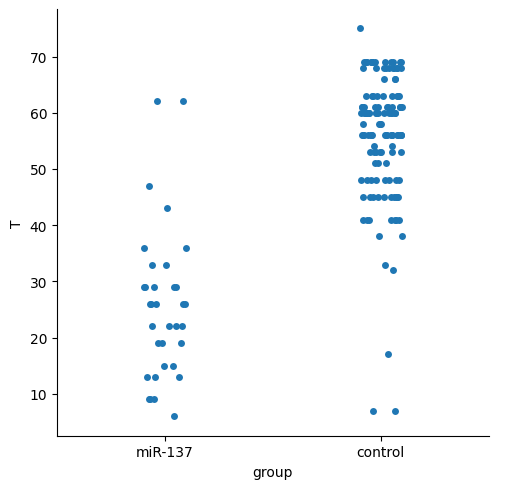

In [5]:
sns.catplot(
    data=df,
    x='group',
    y='T'
)

Parece que el grupo miR-137 tuvo una menor sobrevida, lo analizaremos a detalle más adelante.

Lifelines provee gráficos específicos para la exploración de los análisis de supervivencia dentro de `lifelines.plotting`.
Utilizaremos primero `ll.plotting.plot_lifetimes`.

c:\Users\User\Documents\coding\curso_python\.venv\Lib\site-packages\lifelines\plotting.py:773: UserWarning: For less visual clutter, you may want to subsample to less than 25 individuals.
  warnings.warn(


<Axes: >

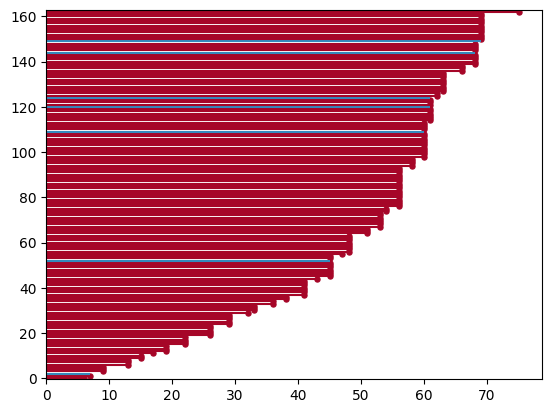

In [15]:

ll.plotting.plot_lifetimes(df['T'], df['E'])

La función arroja una advertencia sobre el número de individuos, pero el gráfico es interpretable. Las líneas rojas son los eventos observados y los azules son los no observados. Veamos una muestra aleatoria de 25 individuos de este datasets.

<Axes: >

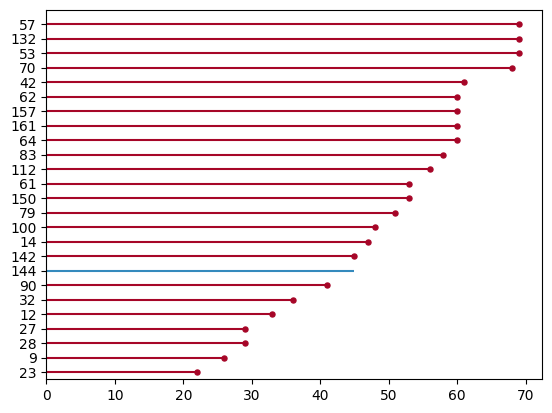

In [16]:
sample = df.sample(n=25)
ll.plotting.plot_lifetimes(sample['T'], sample['E'])


Podemos comenzar a analizar la sobrevida utilizando `scipy`, para ello, necesitamos convertir los datos a un objeto `CensoredData` donde especificaremos los datos observados y aquellos con algún tipo de censura.

## Curvas de sobrevida

Text(0.5, 0, 'Función de sobrevida')

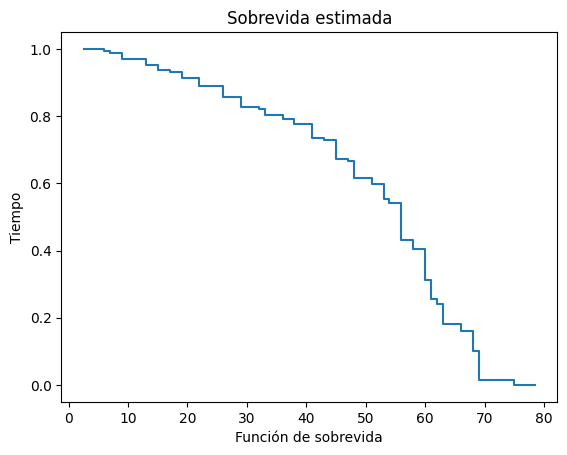

In [23]:
cd = stats.CensoredData(
    uncensored=df[df['E']==1]['T'], # seleccionamos solo a los que observamos E
    right=df[df['E']==0]['T'], # quienes desconocemos su desenlace
)
stats.ecdf(cd).sf.plot()
plt.title('Sobrevida estimada')
plt.ylabel('Tiempo')
plt.xlabel('Función de sobrevida')

Este gráfico es simple y útil pero con limitaciones para análisis más complejos, utilizaremos `lifelines.`


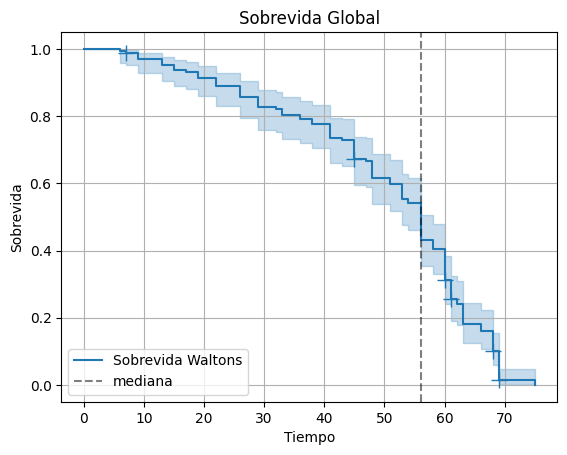

In [50]:
# Primero inicializamos el estimador de Kaplan-Meier.
km = ll.KaplanMeierFitter(label='Sobrevida Waltons')
km.fit(
    durations=df['T'],
    event_observed=df['E']
)
km.plot_survival_function(
    show_censors=True
)

plt.title('Sobrevida Global')
plt.ylabel('Sobrevida')
plt.xlabel('Tiempo')
plt.axvline(km.median_survival_time_, ls='--', color='k', alpha=0.5, label='mediana')
plt.legend()
plt.grid()

Podemos obtener información cuantitativa también.

Ahora separaremos por grupos de forma dinámica, aquí solo hay dos grupos, pero este código funcionaría incluso con más.

Text(0.5, 0, 'Tiempo')

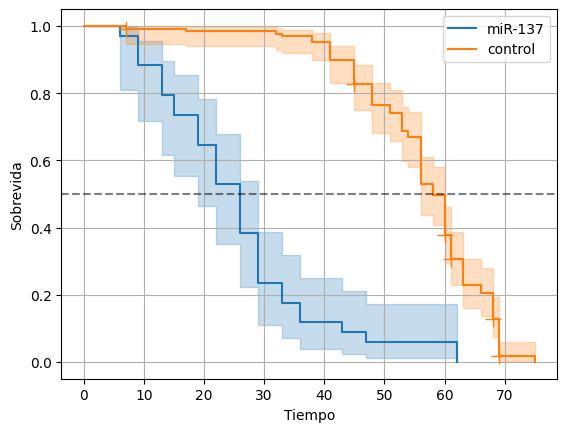

In [56]:
for group in df['group'].unique():
    km = ll.KaplanMeierFitter(label=group)
    cond = df['group'] == group
    km.fit(df[cond]['T'], df[cond]['E'])
    km.plot_survival_function(show_censors=True)
plt.grid()
plt.axhline(0.5, ls='--', color='k', alpha=0.5, label='mediana')
plt.ylabel('Sobrevida')
plt.xlabel('Tiempo')

Comprobemos la significancia con la prueba de log-rank. Primero revisemos la documentación.


In [54]:
help(ll.statistics.logrank_test)

Help on function logrank_test in module lifelines.statistics:

logrank_test(
    durations_A,
    durations_B,
    event_observed_A=None,
    event_observed_B=None,
    t_0=-1,
    weights_A=None,
    weights_B=None,
    weightings=None,
    **kwargs
) -> lifelines.statistics.StatisticalResult
    Measures and reports on whether two intensity processes are different. That is, given two
    event series, determines whether the data generating processes are statistically different.
    The test-statistic is chi-squared under the null hypothesis. Let :math:`h_i(t)` be the hazard ratio of
    group :math:`i` at time :math:`t`, then:

    .. math::
        \begin{align}
         & H_0: h_1(t) = h_2(t) \\
         & H_A: h_1(t) = c h_2(t), \;\; c \ne 1
        \end{align}

    This implicitly uses the log-rank weights.

    Note
    -----
    - *lifelines* logrank implementation only handles right-censored data.

    - The logrank test has maximum power when the assumption of proportional ha

## Log-Rank

In [55]:
cond = df['group'] == 'control'
controls = df[cond]
mir = df[~cond] # operador not

ll.statistics.logrank_test(
    durations_A=controls['T'],
    durations_B=mir['T'],
    event_observed_A=controls['E'],
    event_observed_B=mir['E'],
)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         122.25 <0.005     91.99

## Sobrevida condicional

La **sobrevida condicional** responde a preguntas como:  
> “¿Cuál es la probabilidad de que un individuo sobreviva 10 días más, dado que ya ha sobrevivido los primeros 20?”

Matemáticamente, se define como:

$$
S(t \mid t > t_0) = \frac{S(t)}{S(t_0)}
$$

donde \( S(t) \) es la función de sobrevida acumulada, y \( t_0 \) es el tiempo a partir del cual se condiciona la probabilidad de seguir sobreviviendo.

Esto es útil en seguimiento clínico, por ejemplo, para pacientes que ya han superado una etapa crítica y queremos estimar su pronóstico futuro.

### Ejemplo global

Supongamos que queremos saber cuál es la probabilidad de que un individuo sobreviva al menos 10 días más, **dado que ya ha sobrevivido 15 días**.


In [62]:

# Ajustamos el modelo Kaplan-Meier
km = ll.KaplanMeierFitter()
km.fit(durations=df['T'], event_observed=df['E'])

# Obtenemos la sobrevida en t = 15 y t = 25
S_15, S_25 = km.survival_function_at_times([15, 25])

# Sobrevida condicional: probabilidad de sobrevivir hasta 25, dado que llegó a 15
cond_surv = S_25 / S_15
print(f"Probabilidad de sobrevivir 10 días más (de 15 a 25), dado que llegó a 15: {cond_surv:.3f}")

Probabilidad de sobrevivir 10 días más (de 15 a 25), dado que llegó a 15: 0.947


## Ejercicios
1. Explora las opciones disponibles en `lifelines.datasets` y prueba tus conocimientos con estos datasets.
2. El objeto `cd` de `scipy` ofrece un interfaz sencilla para obtener información de sobrevida. Revisa la documentación para ver qué puede hacer. Te sugiero iniciar por [aquí](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ecdf.html) y [aquí](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.CensoredData.html#scipy.stats.CensoredData).
3. Compara la sobrevida condicionada entre los controles y el grupo de estudio.
4. Revisa la documentación de [lifelines](https://lifelines.readthedocs.io/en/latest/Quickstart.html) para ver otros ejemplos.
5. Aplica lo aprendido con tus propios datos.